In [ ]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from tensorflow.python.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorboard import summary as summary_lib


from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

1.14.0-rc1


In [ ]:
import io
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

df=pd.read_csv('./gdrive/My Drive/Colab/Data/poly_nuc.csv')
df.head(5)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Transcript  ...                                           sequence
0  MSTRG.11448.14  ...  TTTAAAACCCAATTTTTGTTCTCAACTTGAAAAGGGAACACTTTTT...
1  MSTRG.11448.15  ...  TTTAAAACCCAATTTTTGTTCTCAACTTGAAAAGGGAACACTTTTT...
2    MSTRG.4613.1  ...  CAGCTAATCATTTCCAAAGGTTAGTATCTCCCTGCTGACCTCTTCT...
3    MSTRG.8499.1  ...  TGGGAGGATCACTTGAGGCCAGGAGTTCAAGGCAGCAGTGAGCTAT...
4   MSTRG.10696.1  ...  CTTCGGTTGAAATGATTGCATGTTTTTGTCCTTCATTCTTTTGAAA...

[5 rows x 8 columns]

In [ ]:

df_exp=pd.read_csv('./gdrive/My Drive/Colab/Data/expression_autoencoder_10.csv')
df_exp = df_exp.loc[:, 'EC1':'transcript']
df_exp.rename(columns={'transcript':'Transcript'}, inplace=True)
df_exp.head(5)

EC1       EC2        EC3  ...       EC9      EC10       Transcript
0 -11.457929  2.687776   4.594523  ... -1.608713 -0.336352  ENST00000618882
1  -1.347425  0.424789 -10.671882  ... -7.950703 -5.234232  ENST00000618885
2   4.917476  1.415332  -2.071350  ... -0.737849 -1.111489    MSTRG.29225.1
3   8.263896  3.921853  -3.133370  ... -4.640925 -0.109727    MSTRG.64127.2
4   5.946897  3.414431  -3.267882  ... -2.082799 -1.579497    MSTRG.64127.1

[5 rows x 11 columns]

# Poly A


In [ ]:
df.groupby('polya_status')['Transcript'].nunique()

polya_status
.     53084
A+    16112
A-     9318
Name: Transcript, dtype: int64

In [ ]:
df.groupby('polya_gm12878')['Transcript'].nunique()

polya_gm12878
.     75040
A+     2357
A-     1117
Name: Transcript, dtype: int64

In [ ]:
df.groupby('polya_k562')['Transcript'].nunique()

polya_k562
.     75318
A+     2301
A-      895
Name: Transcript, dtype: int64

In [ ]:
df.groupby(['polya_status', 'polya_gm12878', 'polya_k562']).size()

polya_status  polya_gm12878  polya_k562
.             .              .             51500
                             A+              582
                             A-              153
              A+             .               459
                             A+               91
              A-             .               280
                             A+                1
                             A-               18
A+            .              .             13428
                             A+              872
                             A-                2
              A+             .              1055
                             A+              751
              A-             .                 3
                             A-                1
A-            .              .              8002
                             A+                4
                             A-              497
              A+             .                 1
              A-             

In [ ]:
dic_1 = {'.': 2,
     'A+': 1,
     'A-': 0}

df = df[["Transcript",'sequence', 'polya_status',"polya_gm12878","polya_k562"]]


df.iloc[:,2:] = df.iloc[:,2:].applymap(dic_1.get)


df.head(5)

Transcript  ... polya_k562
0  MSTRG.11448.14  ...          2
1  MSTRG.11448.15  ...          2
2    MSTRG.4613.1  ...          2
3    MSTRG.8499.1  ...          2
4   MSTRG.10696.1  ...          2

[5 rows x 5 columns]

In [ ]:
df['status'] = None


#%%
df.loc[(df.polya_status==1) | ((df.polya_status!=0) & (df.polya_gm12878==1) & (df.polya_k562!=0)) | ((df.polya_status==1) & (df.polya_k562==1) & (df.polya_gm12878!=0)) , 'status'] = '1'
print(df.head(10))

#%%
df.loc[(df.polya_status==0) | ((df.polya_status!=1) & (df.polya_gm12878==0) & (df.polya_k562!=1)) | ((df.polya_status!=1) & (df.polya_k562==0) & (df.polya_gm12878!=1)) , 'status'] = '0'
print(df.head(10))

df = df[["Transcript",'sequence', 'status']]

        Transcript  ... status
0   MSTRG.11448.14  ...   None
1   MSTRG.11448.15  ...   None
2     MSTRG.4613.1  ...   None
3     MSTRG.8499.1  ...   None
4    MSTRG.10696.1  ...   None
5    MSTRG.2796.13  ...      1
6    MSTRG.11041.1  ...   None
7     MSTRG.1565.1  ...   None
8     MSTRG.5130.1  ...   None
9  ENST00000473868  ...   None

[10 rows x 6 columns]
        Transcript  ... status
0   MSTRG.11448.14  ...   None
1   MSTRG.11448.15  ...   None
2     MSTRG.4613.1  ...   None
3     MSTRG.8499.1  ...   None
4    MSTRG.10696.1  ...   None
5    MSTRG.2796.13  ...      1
6    MSTRG.11041.1  ...   None
7     MSTRG.1565.1  ...   None
8     MSTRG.5130.1  ...   None
9  ENST00000473868  ...   None

[10 rows x 6 columns]


In [ ]:
df = df.mask(df.eq('None')).dropna()

df.groupby('status')['Transcript'].nunique()

status
0     9769
1    16662
Name: Transcript, dtype: int64

In [ ]:
df = df.join(df_exp.set_index('Transcript'), on='Transcript')
df.shape

(26431, 13)

In [ ]:
df.head(3)

Transcript  ...       EC10
5     MSTRG.2796.13  ...  37.326603
17     MSTRG.109.16  ...   0.774072
18  ENST00000482074  ...  14.194580

[3 rows x 13 columns]

In [ ]:
df_exp=df.iloc[:,3:13]

In [ ]:
df = df[['sequence', 'status']]
#df = df.drop(df[df.polya_status >= 2].index)
#df = df[['sequence', 'polya_status']]

In [ ]:
df.shape

(26431, 2)

In [ ]:
df.groupby('status')['sequence'].nunique()

status
0     9769
1    16662
Name: sequence, dtype: int64

In [ ]:
# function to convert sequence strings into k-mer words, default size = 6 (hexamer words)
def getKmers(sequence, size=3):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]
  
def getSeqChunks(sequence, n=1):
    return [sequence[i:i+n].lower() for i in range(0, len(sequence), n)]
  
df['words'] = df.apply(lambda x: getKmers(x['sequence']), axis=1)
#df['words'] = df.apply(lambda x: getSeqChunks(x['sequence']), axis=1)
df = df.drop('sequence', axis=1)
df.head(5)

status                                              words
5       1  [cca, cag, agc, gcc, ccc, ccg, cga, gag, agg, ...
17      1  [agg, ggg, ggg, ggg, ggt, gtc, tct, ctt, ttc, ...
18      1  [tcc, cct, ctg, tgc, gcc, cct, ctc, tcc, ccc, ...
25      1  [cct, ctg, tgg, gga, gag, aga, gat, atg, tgc, ...
26      1  [act, ctg, tgt, gtc, tct, ctg, tgc, gca, cat, ...

In [ ]:
#dividing data lables
df_texts = list(df['words'])
for item in range(len(df_texts)):
    df_texts[item] = ' '.join(df_texts[item])
y_h = df.iloc[:, 0].values
y_h = y_h.astype(int)

from keras.utils import to_categorical
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_h), 
                y_h)

#y_h = to_categorical(y_h)
class_dict = { 0 : class_weights[0], 1 : class_weights[1]}
print(class_dict)

{0: 1.352799672433207, 1: 0.7931520825831233}


Using TensorFlow backend.


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,4)) # 3,6 good with 8gramm, 6 6, 7-7 0.8125
vectorizer.fit(df_texts)
df_texts = vectorizer.transform(df_texts)

from sklearn.feature_extraction.text import TfidfTransformer
#tf_transformer = TfidfTransformer(use_idf=True).fit(df_texts)
tf_transformer = TfidfTransformer(use_idf=False).fit(df_texts)
df_texts  = tf_transformer.transform(df_texts)
df_texts = pd.DataFrame(df_texts.todense())


In [ ]:
print(df_texts.shape)
df_texts.head(5)

(26431, 5440)


0         1         2     3     ...  5436      5437  5438      5439
0  0.120686  0.040229  0.008046   0.0  ...   0.0  0.008046   0.0  0.024137
1  0.000000  0.000000  0.000000   0.0  ...   0.0  0.000000   0.0  0.000000
2  0.020549  0.005137  0.000000   0.0  ...   0.0  0.000000   0.0  0.000000
3  0.042865  0.000000  0.000000   0.0  ...   0.0  0.000000   0.0  0.000000
4  0.064876  0.016219  0.000000   0.0  ...   0.0  0.000000   0.0  0.000000

[5 rows x 5440 columns]

In [ ]:
df_exp.index = np.arange(len(df_exp))
df_exp.shape

(26431, 10)

In [ ]:
df_texts = pd.concat([df_texts, df_exp], axis=1, sort=False)
df_texts.head(5)

0         1         2  ...        EC8        EC9       EC10
0  0.120686  0.040229  0.008046  ... -43.985077  48.837900  37.326603
1  0.000000  0.000000  0.000000  ...  -1.842319  -2.939954   0.774072
2  0.020549  0.005137  0.000000  ...   5.071561  13.208219  14.194580
3  0.042865  0.000000  0.000000  ...  -8.723573   8.121308  11.585185
4  0.064876  0.016219  0.000000  ...  84.730995  69.962050  71.659150

[5 rows x 5450 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler


col_names = ['EC1', 'EC2', "EC3", "EC4", "EC5", 'EC6', 'EC7', "EC8", "EC9", "EC10"]
features = df_texts[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)


df_texts[col_names] = features
df_texts.head(5)

0         1         2    3  ...       EC7       EC8       EC9      EC10
0  0.120686  0.040229  0.008046  0.0  ...  0.616174 -1.698576  1.048524  1.184927
1  0.000000  0.000000  0.000000  0.0  ... -0.080925  0.256671 -0.421306 -0.104549
2  0.020549  0.005137  0.000000  0.0  ...  0.220302  0.577446  0.037096  0.368891
3  0.042865  0.000000  0.000000  0.0  ... -0.329585 -0.062590 -0.107307  0.276838
4  0.064876  0.016219  0.000000  0.0  ...  0.336097  4.273309  1.648180  2.396088

[5 rows x 5450 columns]

In [ ]:
df_texts = df_texts.assign(pred=y_h)
df_texts.head()

0         1         2    3  ...       EC8       EC9      EC10  pred
0  0.120686  0.040229  0.008046  0.0  ... -1.698576  1.048524  1.184927     1
1  0.000000  0.000000  0.000000  0.0  ...  0.256671 -0.421306 -0.104549     1
2  0.020549  0.005137  0.000000  0.0  ...  0.577446  0.037096  0.368891     1
3  0.042865  0.000000  0.000000  0.0  ... -0.062590 -0.107307  0.276838     1
4  0.064876  0.016219  0.000000  0.0  ...  4.273309  1.648180  2.396088     1

[5 rows x 5451 columns]

In [ ]:
df_texts.isnull().values.any()

False

In [ ]:
df_texts.to_csv('./gdrive/My Drive/Colab/Data/fasta_expression.csv', index=False)

### Lightgbm

In [ ]:
import io
import pandas as pd
import numpy as np

from google.colab import drive
drive.mount('/content/gdrive')

df_texts=pd.read_csv('./gdrive/My Drive/Colab/Data/fasta_expression.csv')
df_texts.head(5)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


0         1         2    3  ...       EC8       EC9      EC10  pred
0  0.120686  0.040229  0.008046  0.0  ... -1.698576  1.048524  1.184927     1
1  0.000000  0.000000  0.000000  0.0  ...  0.256671 -0.421306 -0.104549     1
2  0.020549  0.005137  0.000000  0.0  ...  0.577446  0.037096  0.368891     1
3  0.042865  0.000000  0.000000  0.0  ... -0.062590 -0.107307  0.276838     1
4  0.064876  0.016219  0.000000  0.0  ...  4.273309  1.648180  2.396088     1

[5 rows x 5451 columns]

In [ ]:
#df_texts.iloc[:,-1]
#df_texts.iloc[:,:-1]

In [ ]:
from sklearn.model_selection import train_test_split
#Tain / test
X_t, X_test, y_t, y_test = train_test_split(df_texts.iloc[:,:-1], df_texts.iloc[:,-1], test_size=0.2, random_state=42)
#Tain / validation
X_train, X_val, y_train, y_val = train_test_split(X_t, y_t, test_size=0.2, random_state=42)

In [ ]:
import lightgbm as lgbm
# parameters for LightGBMClassifier
params = {
    'objective' :'binary',
    'learning_rate' : 0.02,
    'num_leaves' : 76,
    'feature_fraction': 0.64, 
    'bagging_fraction': 0.8, 
    'bagging_freq':1,
    'boosting_type' : 'gbdt',
    'metric': ['binary_logloss', 'AUC']
}

# making lgbm datasets for train and valid
d_train = lgbm.Dataset(X_train, y_train)
d_valid = lgbm.Dataset(X_val, y_val)
    
# training with early stop
bst = lgbm.train(params, d_train, 5000, valid_sets=[d_valid], verbose_eval=20, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[20]	valid_0's auc: 0.979888	valid_0's binary_logloss: 0.470088
[40]	valid_0's auc: 0.982737	valid_0's binary_logloss: 0.357012
[60]	valid_0's auc: 0.984612	valid_0's binary_logloss: 0.288461
[80]	valid_0's auc: 0.98603	valid_0's binary_logloss: 0.24321
[100]	valid_0's auc: 0.986789	valid_0's binary_logloss: 0.209579
[120]	valid_0's auc: 0.987095	valid_0's binary_logloss: 0.187476
[140]	valid_0's auc: 0.987455	valid_0's binary_logloss: 0.171394
[160]	valid_0's auc: 0.987948	valid_0's binary_logloss: 0.158857
[180]	valid_0's auc: 0.988096	valid_0's binary_logloss: 0.151271
[200]	valid_0's auc: 0.988546	valid_0's binary_logloss: 0.143966
[220]	valid_0's auc: 0.988846	valid_0's binary_logloss: 0.138501
[240]	valid_0's auc: 0.989068	valid_0's binary_logloss: 0.134485
[260]	valid_0's auc: 0.989342	valid_0's binary_logloss: 0.131322
[280]	valid_0's auc: 0.989513	valid_0's binary_logloss: 0.128909
[300]	valid_0's auc: 0.989774	val

Overall accuracy of Light GBM model: 0.9576319273690184


AUC score: 0.9904338525015988


<Figure size 432x288 with 0 Axes>

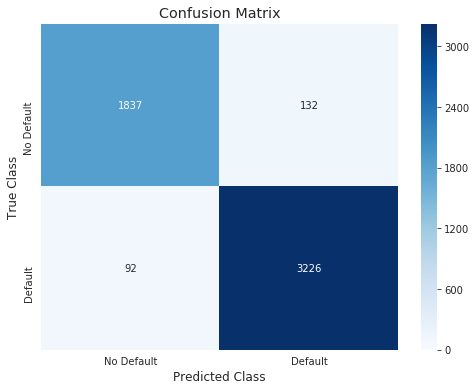

In [ ]:
predictions_lgbm_prob = bst.predict(X_test)
predictions_lgbm_01 = np.where(predictions_lgbm_prob > 0.5, 1, 0) #Turn probability to 0-1 binary output

from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
import seaborn as sns
sns.set_style("whitegrid")

#Print accuracy
acc_lgbm = accuracy_score(y_test, predictions_lgbm_01)
print('Overall accuracy of Light GBM model:', acc_lgbm)

#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions_lgbm_prob)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

#Print Confusion Matrix
plt.figure()
cm = confusion_matrix(y_test, predictions_lgbm_01)
labels = ['No Default', 'Default']
plt.figure(figsize=(8,6))
sns.heatmap(cm, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="Blues", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
import pickle
import pandas as pd


from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform


import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV

clf = lgb.LGBMRegressor()

param_grid ={'objective' :"binary",
             'n_estimators':sp_randint(3000, 15000),
             'num_leaves': sp_randint(100, 250), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             'learning_rate':[0.001,0.01, 0.1, 0.2, 0.3]}

fit_params = {'eval_metric': 'rmse',
              'early_stopping_rounds': 30,
              'eval_set': [(X_valid, Y_valid)]}

rs_clf = RandomizedSearchCV(clf, param_grid, n_iter=10,
                            n_jobs=-1, verbose=2, cv=3,
                            fit_params=fit_params,
                            scoring='neg_mean_squared_error', refit=False, random_state=42)
print("Randomized search..")

rs_clf.fit(X_train, Y_train)


best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(best_score))
print("Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

### simple model

In [ ]:
from keras.regularizers import l1
from keras.regularizers import l2

#optimizer = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim,activation='relu',kernel_regularizer=l1(0.01), activity_regularizer=l1(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='relu', kernel_regularizer=l1(0.01))) #80
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                54510     
_________________________________________________________________
batch_normalization_4 (Batch (None, 10)                40        
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 33        
_________________________________________________________________
batch_normalization_5 (Batch (None, 3)                 12        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 4         
Total params: 54,599
Trainable params: 54,573
Non-trainable params: 26
_________________________________________________________________


In [ ]:
from keras.regularizers import l1
from keras.regularizers import l2

#optimizer = keras.optimizers.SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
optimizer = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

input_dim = X_train.shape[1]  # Number of features
model = Sequential()
model.add(layers.Dense(10, input_dim=input_dim, activation='relu',kernel_regularizer=l1(0.01), activity_regularizer=l1(0.01)))
model.add(layers.BatchNormalization())
model.add(layers.Dense(3, activation='relu', activity_regularizer=l1(0.01))) #80
model.add(layers.BatchNormalization())
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train,
                     class_weight = class_dict,
                     epochs=100,
                     verbose=True,
                     validation_data=(X_val, y_val),
                     batch_size=128, callbacks=[checkpoint, eas])
plot_history(history)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
# model 3*(8:8)0.2

In [ ]:
from keras.callbacks import ModelCheckpoint
# Save the checkpoint in the /output folder
filepath = "./gdrive/My Drive/Colab/Data/polyA_exp.hdf5"

# Keep only a single checkpoint, the best over test accuracy.
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss',
                                             verbose=0, save_best_only=True, save_weights_only=True, mode='auto', save_freq=1)

eas = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0,
                              mode='auto', baseline=None, restore_best_weights=True)

Train on 16915 samples, validate on 4229 samples
Epoch 1/100
16915/16915 [==============================] - 7s 434us/sample - loss: 1.3900 - acc: 0.9345 - val_loss: 0.7528 - val_acc: 0.6250
Epoch 2/100
16915/16915 [==============================] - 7s 396us/sample - loss: 0.3134 - acc: 0.9578 - val_loss: 0.6571 - val_acc: 0.6824
Epoch 3/100
16915/16915 [==============================] - 7s 397us/sample - loss: 0.2952 - acc: 0.9578 - val_loss: 0.4465 - val_acc: 0.9482
Epoch 4/100
16915/16915 [==============================] - 7s 405us/sample - loss: 0.2782 - acc: 0.9571 - val_loss: 0.3280 - val_acc: 0.9546
Epoch 5/100
16915/16915 [==============================] - 7s 401us/sample - loss: 0.2711 - acc: 0.9558 - val_loss: 0.2634 - val_acc: 0.9624
Epoch 6/100
16915/16915 [==============================] - 7s 401us/sample - loss: 0.2490 - acc: 0.9577 - val_loss: 0.2688 - val_acc: 0.9565
Epoch 7/100
16915/16915 [==============================] - 7s 403us/sample - loss: 0.2451 - acc: 0.9612 -

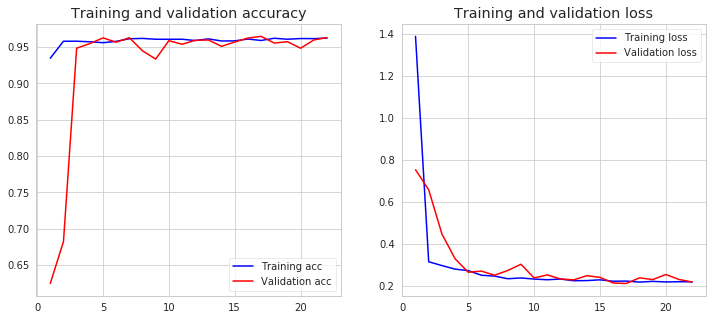

In [ ]:
class_dict = {0: 1.352799672433207, 1: 0.7931520825831233}



history = model.fit(X_train, y_train,
                     class_weight = class_dict,
                     epochs=100,
                     verbose=True,
                     validation_data=(X_val, y_val),
                     batch_size=128, callbacks=[eas])
plot_history(history)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
# model 3*(8:8)0.2

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1


score = model.evaluate(X_test, y_test, verbose=3)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

y_pred = model.predict_classes(X_test)
pred = y_pred.reshape((-1))


act = y_test
print(pd.crosstab(act, pred, rownames=['Real'], colnames=['Predicted'], margins=True))
accuracy, precision, recall, f1 = get_metrics(y_test, y_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Test loss: 0.21167176587749165
Test accuracy: 0.96311706
Predicted     0     1   All
Real                       
0          1884    85  1969
1           110  3208  3318
All        1994  3293  5287
accuracy = 0.963 
precision = 0.963 
recall = 0.963 
f1 = 0.963


In [ ]:
from sklearn import datasets
from sklearn.externals import joblib
# Saving the results
model.save('./gdrive/My Drive/Colab/Data/poly_a_7599.h5')
joblib.dump(vectorizer, './gdrive/My Drive/Colab/Data/vectorizer_poly_a.joblib')
joblib.dump(tf_transformer, './gdrive/My Drive/Colab/Data/transformer_poly_a.joblib')

['./gdrive/My Drive/Colab/Data/transformer_poly_a.joblib']